In [ ]:
# Copyright 2025 Google LLC
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Supervised Fine Tuning with Automatic GenAI Evaluation

<table align="left">
  <td style="text-align: center">
    <a href="https://colab.research.google.com/github/GoogleCloudPlatform/generative-ai/blob/main/gemini/tuning/sft_gemini_automatic_evaluation.ipynb">
      <img width="32px" src="https://www.gstatic.com/pantheon/images/bigquery/welcome_page/colab-logo.svg" alt="Google Colaboratory logo"><br> Open in Colab
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/colab/import/https:%2F%2Fraw.githubusercontent.com%2FGoogleCloudPlatform%2Fgenerative-ai%2Fmain%2Fgemini%2Ftuning%2Fsft_gemini_automatic_evaluation.ipynb">
      <img width="32px" src="https://lh3.googleusercontent.com/JmcxdQi-qOpctIvWKgPtrzZdJJK-J3sWE1RsfjZNwshCFgE_9fULcNpuXYTilIR2hjwN" alt="Google Cloud Colab Enterprise logo"><br> Open in Colab Enterprise
    </a>
  </td>    
  <td style="text-align: center">
    <a href="https://console.cloud.google.com/vertex-ai/workbench/deploy-notebook?download_url=https://raw.githubusercontent.com/GoogleCloudPlatform/generative-ai/main/gemini/tuning/sft_gemini_automatic_evaluation.ipynb">
      <img src="https://www.gstatic.com/images/branding/gcpiconscolors/vertexai/v1/32px.svg" alt="Vertex AI logo"><br> Open in Workbench
    </a>
  </td>
  <td style="text-align: center">
    <a href="https://github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/tuning/sft_gemini_automatic_evaluation.ipynb">
      <img width="32px" src="https://www.svgrepo.com/download/217753/github.svg" alt="GitHub logo"><br> View on GitHub
    </a>
  </td>
</table>

<div style="clear: both;"></div>

<b>Share to:</b>

<a href="https://www.linkedin.com/sharing/share-offsite/?url=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/tuning/sft_gemini_automatic_evaluation.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/8/81/LinkedIn_icon.svg" alt="LinkedIn logo">
</a>

<a href="https://bsky.app/intent/compose?text=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/tuning/sft_gemini_automatic_evaluation.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/7/7a/Bluesky_Logo.svg" alt="Bluesky logo">
</a>

<a href="https://twitter.com/intent/tweet?url=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/tuning/sft_gemini_automatic_evaluation.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/5/5a/X_icon_2.svg" alt="X logo">
</a>

<a href="https://reddit.com/submit?url=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/tuning/sft_gemini_automatic_evaluation.ipynb" target="_blank">
  <img width="20px" src="https://redditinc.com/hubfs/Reddit%20Inc/Brand/Reddit_Logo.png" alt="Reddit logo">
</a>

<a href="https://www.facebook.com/sharer/sharer.php?u=https%3A//github.com/GoogleCloudPlatform/generative-ai/blob/main/gemini/tuning/sft_gemini_automatic_evaluation.ipynb" target="_blank">
  <img width="20px" src="https://upload.wikimedia.org/wikipedia/commons/5/51/Facebook_f_logo_%282019%29.svg" alt="Facebook logo">
</a>            

| Author(s) |
| --- |
| Kelsi Lakey |

# Gen AI Evaluation <> Tuning Integration
Automatically perform Gen AI Evaluation on tuned checkpoints by simply \
including an Evaluation Config in the tuning job definition.


[Configure Gen AI Evaluation Service](https://cloud.devsite.corp.google.com/vertex-ai/generative-ai/docs/models/gemini-use-supervised-tuning#create_a_text_model_supervised_tuning_job)

## Getting Started

### Install Gen AI SDK and other required packages

The new Google Gen AI SDK provides a unified interface to Gemini through both the Gemini Developer API and the Gemini API on Vertex AI. With a few exceptions, code that runs on one platform will run on both. This means that you can prototype an application using the Developer API and then migrate the application to Vertex AI without rewriting your code.


In [ ]:
%pip install --upgrade --user --quiet google-genai google-cloud-aiplatform

### Restart runtime (Colab only)

To use the newly installed packages, you must restart the runtime on Google Colab.


In [ ]:
import sys

if "google.colab" in sys.modules:
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

<div class="alert alert-block alert-warning">
<b>⚠️ The kernel is going to restart. Please wait until it is finished before continuing to the next step. ⚠️</b>
</div>

## Step0: Authenticate your notebook environment (Colab only)

If you are running this notebook on Google Colab, run the cell below to authenticate your environment.

In [ ]:
import sys

if "google.colab" in sys.modules:
    from google.colab import auth

    auth.authenticate_user()

- If you are running this notebook in a local development environment:
  - Install the [Google Cloud SDK](https://cloud.google.com/sdk).
  - Obtain authentication credentials. Create local credentials by running the following command and following the oauth2 flow (read more about the command [here](https://cloud.google.com/sdk/gcloud/reference/beta/auth/application-default/login)):

    ```bash
    gcloud auth application-default login
    ```

## Step1: Import Libraries

In [ ]:
import time

# For data handling.
import pandas as pd
from google import genai
# For extracting vertex experiment details.
from google.cloud import aiplatform
from google.genai import types

## Step2: Set Google Cloud project information and initialize Vertex AI and Gen AI SDK

To get started using Vertex AI, you must have an existing Google Cloud project and [enable the Vertex AI API](https://console.cloud.google.com/flows/enableapi?apiid=aiplatform.googleapis.com).

Learn more about [setting up a project and a development environment](https://cloud.google.com/vertex-ai/docs/start/cloud-environment).


In [ ]:
PROJECT_ID = "[your-project-id]"  # @param {type:"string"}
REGION = "us-central1"  # @param {type:"string"}

In [ ]:
aiplatform.init(project=PROJECT_ID, location=REGION)

client = genai.Client(vertexai=True, project=PROJECT_ID, location=REGION)

### Step2 [a]: Create a Cloud Storage bucket

Create a storage bucket to store intermediate artifacts such as datasets.


In [ ]:
# Provide a bucket name
BUCKET_NAME = "[your-bucket]"  # @param {type:"string"}
BUCKET_URI = f"gs://{BUCKET_NAME}"

Only if your bucket doesn't already exist: Run the following cell to create your Cloud Storage bucket.


In [ ]:
! gsutil mb -l {REGION} -p {PROJECT_ID} {BUCKET_URI}

### Step2 [b]: Set the Tuning and Validation data

- Data used in this notebook is present in the public Google Cloud Storage(GCS) bucket.
- It's in Gemini 2.5 tuning dataset format
- Validation data is required for performing automatic GenAI Evaluation

In [ ]:
TRAINING_DATASET = "gs://cloud-samples-data/ai-platform/generative_ai/gemini-2_0/text/sft_train_data.jsonl"
VALIDATION_DATASET = "gs://cloud-samples-data/ai-platform/generative_ai/gemini-2_0/text/sft_validation_data.jsonl"

### Step2 [c]: Initialize model

The following Gemini text model support supervised tuning:

* `gemini-2.5-flash`

In [ ]:
base_model = "gemini-2.5-flash"

## Step3: Define the Evaluation Config
- `metrics`: Specifies the GenAI Evaluation metrics to evaluate with.
- `output_config`: Path to output evaluation data and results.

*Optional Parameters*
- `autorater_config`: Specific autorater related fields for evaluation.

In [ ]:
evaluation_config = types.EvaluationConfig(
    # Required. Define a list of metrics. A minimum of 1 metric is required
    metrics=[
        types.Metric(
            name="fluency",
            prompt_template="Evaluate the sentence fluency of the response. Provide a score from 1-5.\n RESPONSE: {response}.",
            judge_model_system_instruction="You are a professional editor specializing in linguistics.",  # Optional
        ),
    ],
    # Required. Define the output config
    output_config=types.OutputConfig(
        gcs_destination=types.GcsDestination(
            output_uri_prefix=f"{BUCKET_URI}/evaluation"  # Specify the output location for row based results
        )
    ),
    # Optional. Define an autorater config
    autorater_config=types.AutoraterConfig(
        sampling_count=6,
    ),
)

## Step4: Fine-tune the Model

 - `source_model`: Specifies the base Gemini model version you want to fine-tune.
 - `train_dataset`: Path to your training data in JSONL format.

   *Optional parameters*
 - `validation_dataset`: If provided, this data is used to evaluate the model during tuning. Required for automatic GenAI Evaluation.
 - `evaluation_config`: If provided, automatic GenAI Evaluation will be performed.
 - `tuned_model_display_name`: Display name for the tuned model.
 - `epochs`: The number of training epochs to run.
 - `learning_rate_multiplier`: A value to scale the learning rate during training.
 - `adapter_size` : Gemini 2.5 Flash supports Adapter length [1, 2, 4, 8], default value is 4.

**Note: The default hyperparameter settings are optimized for optimal performance based on rigorous testing and are recommended for initial use. Users may customize these parameters to address specific performance requirements.**

In [ ]:
tuned_model_display_name = "[DISPLAY NAME FOR TUNED MODEL]"  # @param {type:"string"}

training_dataset = {
    "gcs_uri": TRAINING_DATASET,
}

validation_dataset = types.TuningValidationDataset(
    gcs_uri=VALIDATION_DATASET,
)

# Tune a model using `tune` method.
sft_tuning_job = client.tunings.tune(
    base_model=base_model,
    training_dataset=training_dataset,
    config=types.CreateTuningJobConfig(
        tuned_model_display_name=tuned_model_display_name,
        validation_dataset=validation_dataset,
        evaluation_config=evaluation_config,
    ),
)

In [ ]:
# Get the tuning job info.
tuning_job = client.tunings.get(name=sft_tuning_job.name)
tuning_job

**Note: Tuning time depends on several factors, such as training data size, number of epochs, learning rate multiplier, etc.**

<div class="alert alert-block alert-warning">
<b>⚠️ It will take ~45 mins for the model tuning job and evaluation to complete on the provided dataset and set configurations/hyperparameters. ⚠️</b>
</div>

In [ ]:
%%time
# Wait for job completion

running_states = [
    "JOB_STATE_PENDING",
    "JOB_STATE_RUNNING",
]

while tuning_job.state.name in running_states:
    print(".", end="")
    tuning_job = client.tunings.get(name=tuning_job.name)
    time.sleep(10)
print()

In [ ]:
tuned_model = tuning_job.tuned_model.endpoint
experiment_name = tuning_job.experiment

print("Tuned model experiment", experiment_name)
print("Tuned model endpoint resource name:", tuned_model)

## Step5: View GenAI Evaluation results

Evaluation results can be viewed in the associated Vertex Experiment.
- Each checkpoint will be described with a `tuning-evaluation-checkpoint-#` \
Experiment Run. This will include the following GenAI Evaluation metrics:
  - Error message (if failed)
  - gcsDestination (location of row based evaluation results)
  - gcsSource (location of evaluation dataset)
  - Aggregated evaluation metric results
    - For SDK: `AVERAGE` and `STANDARD_DEVIATION` values for each metric
    - For API: User defined aggregation metrics
    - Aggregated results are indexed in the order they were defined in the Evaluation Config

#### Step5 [a]: View GenAI Evaluation Metrics using Vertex AI Experiments SDK

In [ ]:
# Locate Vertex AI Experiment and Vertex AI Experiment Run
experiment_runs = aiplatform.ExperimentRun.list(experiment=experiment_name)
for run in experiment_runs:
    if "-evaluation-" in run.name:
        print(run.name)
        print(pd.DataFrame.from_dict(run.get_metrics(), orient="index"))
        print("\n")

### Step5 [b]: View Tuning Job and Evaluation Results in the Google Cloud Console

The Tuning Job can be viewed in the Google Cloud Console.

Evaluation results can be viewed in the associated Vertex Experiment page.
- Navigate here by selecting the [Experiment link](https://screenshot.googleplex.com/4Yi7AjMoX8juYJt) on the Details page of the Tuning Job.
- Tuning time series metrics are also visible on the Vertex Experiments UI page.

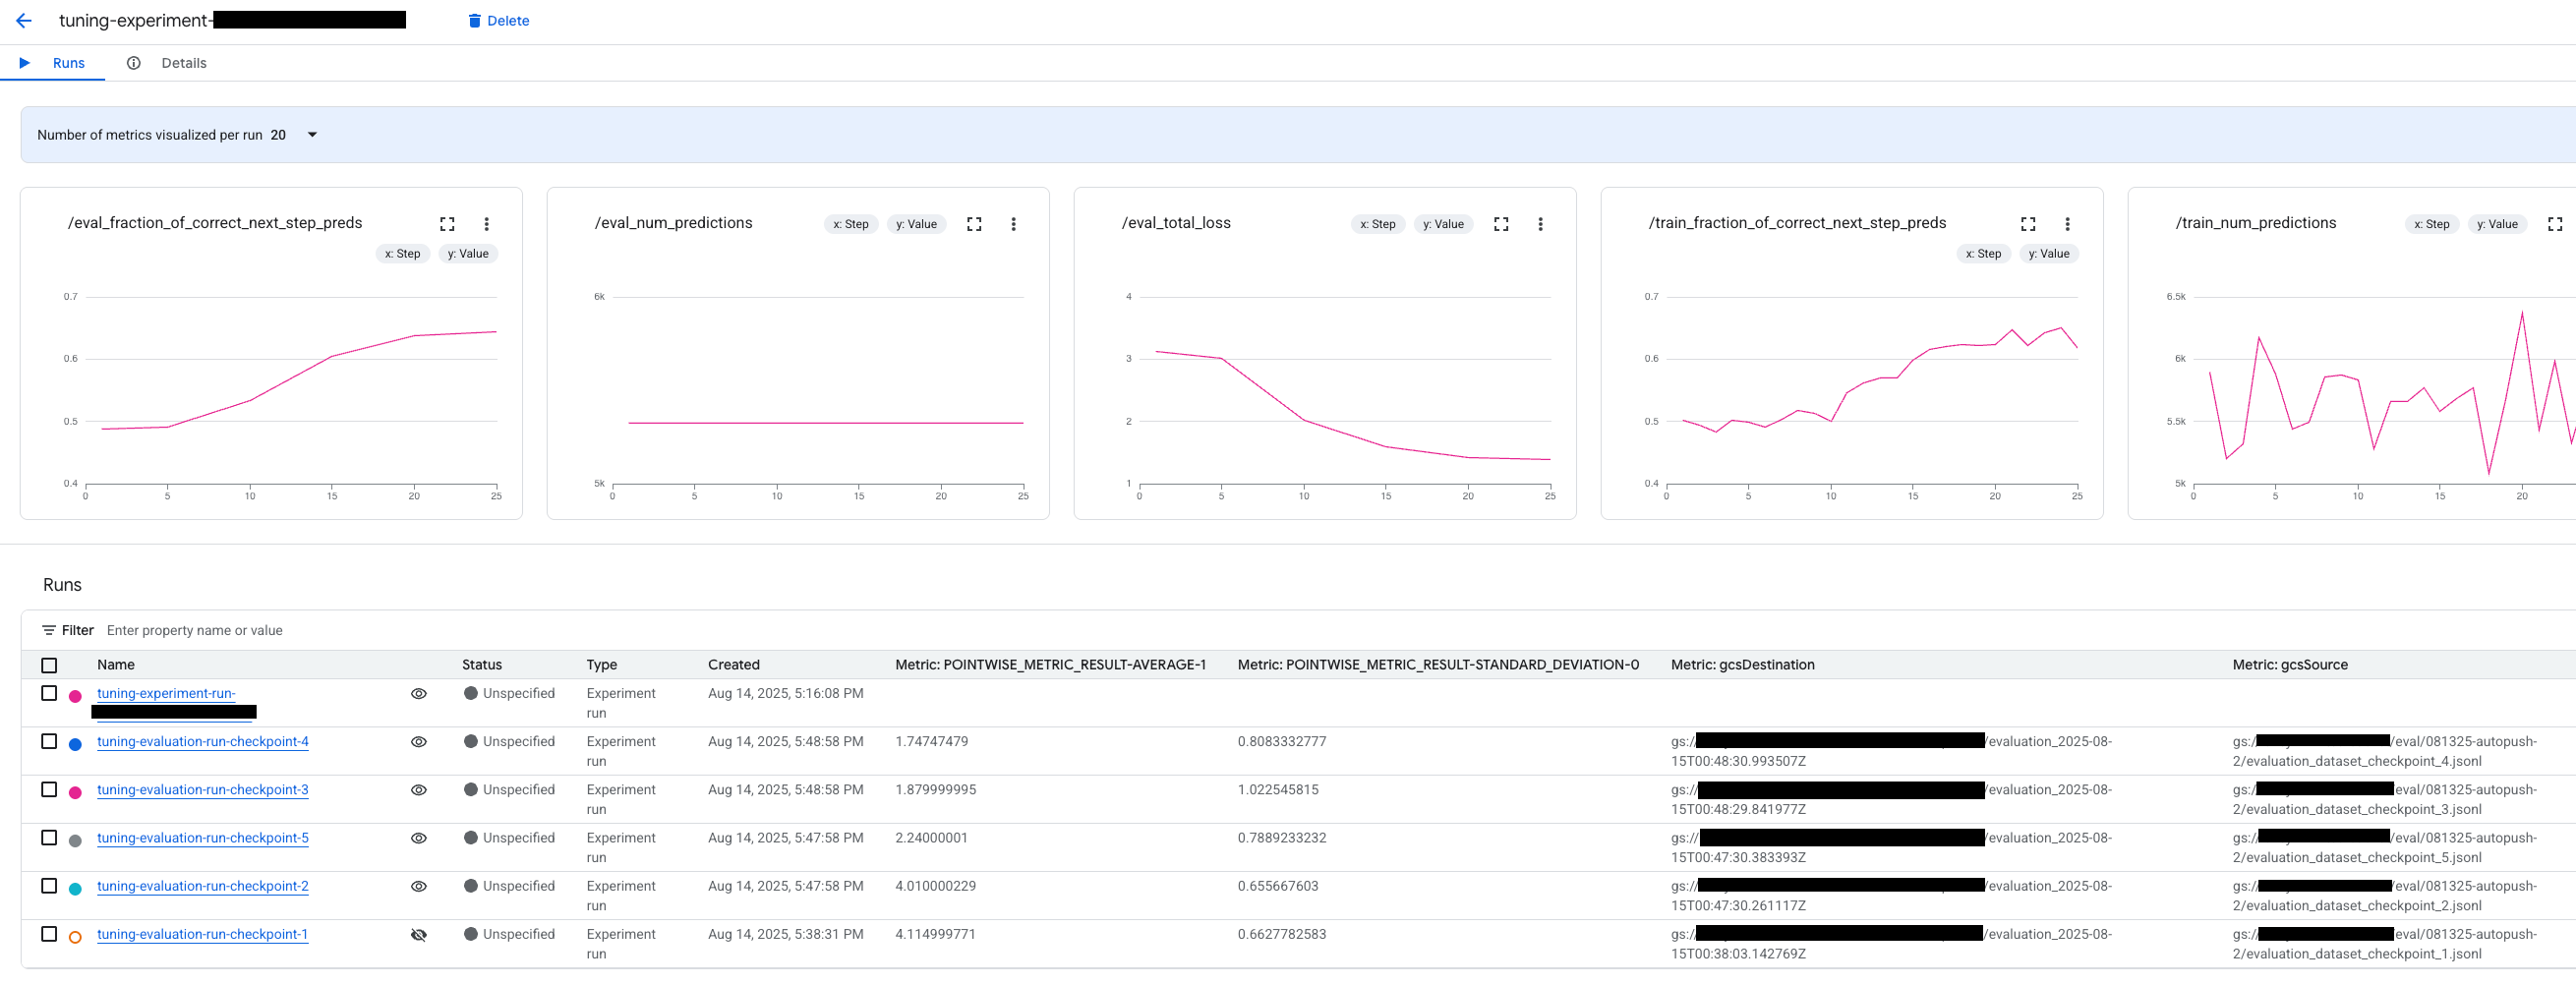